In [1]:
import pandas as pd 
from core.organize_data import organize_data
from core.dataset import time_diff
from core.dataset import create_time_series_dataset,create_ts_dataset
%load_ext autoreload 
%autoreload 2

In [2]:
df_data = pd.read_csv("DATA.csv")
df_data_train, df_data_test = organize_data(df_data)

/Users/scafartogregory/Desktop/PDM/organize_data.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_test["predictive_machine_status"] = df_data_test.apply(
/Users/scafartogregory/Desktop/PDM/organize_data.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_test["predictive_machine_status_label"] = df_data_test["predictive_machine_status"].map(


In [3]:
df_data_train = df_data_train.interpolate(method="linear")
df_data_test = df_data_test.interpolate(method="linear")

/var/folders/g9/w9q193415dqd_3g5fx11gt_40000gn/T/ipykernel_26678/1731967731.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_data_train = df_data_train.interpolate(method="linear")
/var/folders/g9/w9q193415dqd_3g5fx11gt_40000gn/T/ipykernel_26678/1731967731.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_data_test = df_data_test.interpolate(method="linear")


In [4]:
df_data_train = time_diff(df_data_train)
df_data_test = time_diff(df_data_test)

In [5]:
time_steps = 60
df_data_train = create_time_series_dataset(df_data_train, time_steps)

100%|██████████| 210739/210739 [00:08<00:00, 24117.96it/s]


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_data_train[[x for x in df_data_train.keys() if "sensor" in x ]], df_data_train["predictive_machine_status_label"])

In [7]:
df_resampled = pd.DataFrame(X_resampled,columns=[x for x in df_data.keys() if "sensor" in x ])
df_resampled["predictive_machine_status_label"] = y_resampled

In [8]:
X,y = create_ts_dataset(df_data_train,time_steps)

  0%|          | 0/3512 [00:00<?, ?it/s]

100%|██████████| 3512/3512 [00:02<00:00, 1182.73it/s]


In [9]:
import torch 
import torch.nn as nn 
X = torch.stack(X)
y = torch.stack(y)

In [10]:
from core.lstm_utils import MultivariateRNNModel,generate_triplets
from core.dataset import  CustomDataset

In [11]:
data = CustomDataset(X,y)

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(data, batch_size=256, shuffle=True)

In [13]:
triplets = generate_triplets(X,y)

In [14]:
import torch.optim as optim

input_dim = X.shape[2]        
hidden_size = 64       
num_layers = 3         
embedding_size = 125   
margin = 5          

model = MultivariateRNNModel(input_dim, hidden_size, num_layers, 3, dropout=0.1).to("mps")
contrastive_loss_fn = nn.TripletMarginLoss(margin=margin)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
from core.lstm_utils import train_contrastive

model =  train_contrastive(
    model, train_dataloader, optimizer, contrastive_loss_fn, triplets, epochs=3, device="mps"
)

  0%|          | 0/3351 [00:00<?, ?it/s]

100%|██████████| 3351/3351 [01:07<00:00, 49.98it/s]


Epoch [1/3], Loss: 1094.9207946913582


100%|██████████| 3351/3351 [01:07<00:00, 50.01it/s]


Epoch [2/3], Loss: 1131.603836263929


100%|██████████| 3351/3351 [01:06<00:00, 50.03it/s]

Epoch [3/3], Loss: 1043.2916930403028


In [17]:
model.eval()
emb= model(X.to("mps"))

In [18]:
import umap 

In [19]:
umap_model= umap.UMAP(n_components=3)
umap_emb = umap_model.fit_transform(emb.detach().cpu().numpy() )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [29]:
label_mapping = {"DANGER_ZONE": 0, "NORMAL": 1, "MAINTENANCE": 2, "BROKEN": 3}

In [30]:
label_mapping_inv = {v:k for k,v in label_mapping.items()}

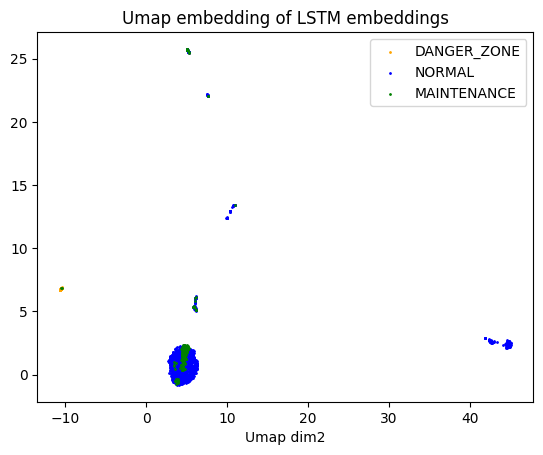

In [33]:
import matplotlib.pyplot as plt 
import numpy as np 

color_dic = {3:"black",
2:"green",
1:"blue",
0:"orange",
"URGENT_DANGER_ZONE":"red"}



unique_labels = np.unique(y)



for label in unique_labels:
    label = int(label)


    idx = np.where(y == label)

    

    points = umap_emb[idx]

    plt.scatter(points[:, 0], points[:, 1], color=color_dic[label],s=1,label=label_mapping_inv[label])
    plt.xlabel("Umap dim1")
    plt.xlabel("Umap dim2")
plt.title("Umap embedding of LSTM embeddings")
plt.legend()